In [94]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch.utils.data
from sklearn.model_selection import train_test_split

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [95]:
train_csv = pd.read_csv("./train/Data_Train.csv", keep_default_na=False)
test_csv = pd.read_csv("./train/Data_Test.csv", keep_default_na=False)

# train = train[0:30]
print(train_csv.columns)

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price'],
      dtype='object')


In [96]:
def convertKgtoL(x):
    if x != "":
        l = x.split(" ") 
        if l[1] and l[1] == "km/kg":
            return float(l[0]) / 0.42
        return l[0]
    return x

def convertCrtoLak(x):
    if x != "":
        l = x.split(" ") 
        if l[1] and l[1] == "Cr":
            return float(l[0]) * 100
        return l[0]
    return x

def convertToBrand(x):
    if x != "":
        l = x.split(" ")
        return l[0].upper()
    return x

def convertYearDiff(x):
    if x != "":
        return 2019 - int(x)
    return x

In [97]:
def preprocess_data(dataset):
    dataset['Power'] = dataset["Power"].replace("bhp", "", regex=True).replace("null", "", regex=True)
    dataset['Power'] = pd.to_numeric(dataset["Power"].str.strip())
    dataset['Engine'] = dataset["Engine"].replace("CC", "", regex=True)
    dataset['Engine'] = pd.to_numeric(dataset["Engine"].str.strip())
    dataset['Mileage'] = dataset["Mileage"].apply(convertKgtoL)
    dataset['Mileage'] = pd.to_numeric(dataset["Mileage"])
    dataset['New_Price'] = dataset["New_Price"].apply(convertKgtoL)
    dataset['New_Price'] = pd.to_numeric(dataset["New_Price"])
    
    dataset['Year_Old'] = dataset["Year"].apply(convertYearDiff)
    dataset['Car_Brand'] = dataset["Name"].apply(convertToBrand)   
    
    
    dataset['Mileage'].fillna(dataset['Mileage'].mean(), inplace=True)
    dataset['Power'].fillna(dataset['Power'].mean(), inplace=True)
    dataset['Engine'].fillna(dataset['Engine'].mean(), inplace=True)
    dataset['New_Price'].fillna(0.0, inplace=True)
     
    dataset = dataset.drop(['Name'],axis=1)
    #dataset = dataset.drop(['Year'],axis=1)
    return dataset

In [98]:
train = preprocess_data(train_csv)
test = preprocess_data(test_csv)

display(train.head())

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Year_Old,Car_Brand
0,Mumbai,2010,72000,CNG,Manual,First,63.333333,998.0,58.16,5,0.00,1.75,9,MARUTI
1,Pune,2015,41000,Diesel,Manual,First,19.670000,1582.0,126.20,5,0.00,12.50,4,HYUNDAI
2,Chennai,2011,46000,Petrol,Manual,First,18.200000,1199.0,88.70,5,8.61,4.50,8,HONDA
3,Chennai,2012,87000,Diesel,Manual,First,20.770000,1248.0,88.76,7,0.00,6.00,7,MARUTI
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.200000,1968.0,140.80,5,0.00,17.74,6,AUDI


In [99]:
train.dtypes

Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                 object
New_Price            float64
Price                float64
Year_Old               int64
Car_Brand             object
dtype: object

In [100]:
cols = ('Location','Fuel_Type','Transmission','Owner_Type','Seats', 'Car_Brand')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) 
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))


In [101]:
display(train.head())

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Year_Old,Car_Brand
0,9,2010,72000,0,1,0,63.333333,998.0,58.16,5,0.00,1.75,9,18
1,10,2015,41000,1,1,0,19.670000,1582.0,126.20,5,0.00,12.50,4,11
2,2,2011,46000,4,1,0,18.200000,1199.0,88.70,5,8.61,4.50,8,10
3,2,2012,87000,1,1,0,20.770000,1248.0,88.76,7,0.00,6.00,7,18
4,3,2013,40670,1,0,2,15.200000,1968.0,140.80,5,0.00,17.74,6,1


In [102]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')
print(train.select_dtypes(include=['object']).columns)

Total Features:  0 categorical + 14 numerical = 14 features
Index([], dtype='object')


In [103]:
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Separating out the features
x = train.values

new_train = train.drop(['Price'], axis=1).astype('float64')
x_train = new_train
x_train_col = new_train.columns
x_test = test.astype('float64')
y_train = train.Price

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_train_set = pd.DataFrame(x_train, columns = x_train_col)

x_test = MinMaxScaler().fit_transform(x_test)

# Separating out the target
y = train.loc[:,['Price']].values

# Standardizing the features
#x = StandardScaler().fit_transform(x)

#x = scale(x)

#display(x)

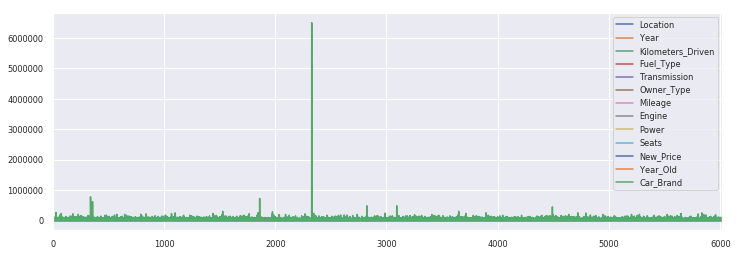

In [104]:
new_train.plot(kind='line',legend=True, figsize=(12,4))

(-1, 12.55)

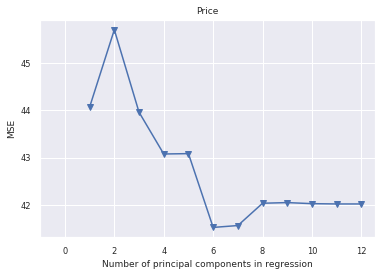

In [105]:
n = len(x_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 13):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(x_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 13), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Scores on LV 2')

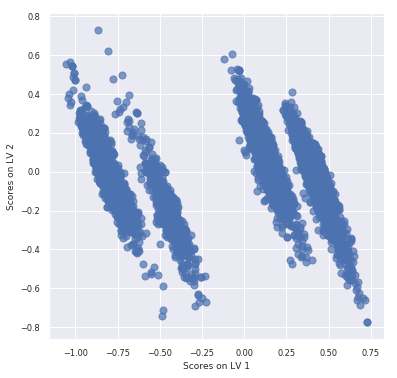

In [116]:
plsr = PLSRegression(n_components=6, scale=False) # <1>
plsr.fit(x_train, y_train) # <2>
#model = plsr.fit_transform(x_train_set, y_train)
scores = pd.DataFrame(plsr.x_scores_)

#print(pd.DataFrame(model.components_,columns=x_train_set.columns,index = ['PS-1','PS-2','PS-3','PS-4','PS-5','PS-6']))
#scores.index=new_train.columns
#cols_frame = plsr.get_support(indices=True)

ax = scores.plot(x=0, y=1, kind='scatter', legend=True, s=50, alpha=0.7, figsize=(6,6))
ax.set_xlabel('Scores on LV 1')
ax.set_ylabel('Scores on LV 2')


In [125]:
print(plsr.coef_.squeeze())
print(list(zip(plsr.coef_.squeeze(), x_train_col)))

[-2.99000926  9.20099221  0.20004633 -1.99633053 -3.10562389 -0.88986678
 -9.37916432 28.55736476 39.56126087 -7.03099115 15.29160881 -9.20099221
 -2.82242661]
[(-2.990009256999319, 'Location'), (9.200992207116252, 'Year'), (0.20004633116822218, 'Kilometers_Driven'), (-1.996330532789143, 'Fuel_Type'), (-3.1056238937793266, 'Transmission'), (-0.889866777326711, 'Owner_Type'), (-9.379164316902493, 'Mileage'), (28.55736476198129, 'Engine'), (39.56126087154277, 'Power'), (-7.030991147444439, 'Seats'), (15.291608806981117, 'New_Price'), (-9.200992207116366, 'Year_Old'), (-2.8224266083886205, 'Car_Brand')]


In [41]:
pca = PCA(n_components=6)

#principalComponents = pca.fit_transform(x)
pca.fit(x)
#principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

#print(pca.components_)
#print(pca.explained_variance_)
#display(principalDf.head())

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

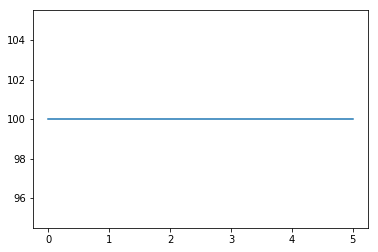

In [42]:
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)

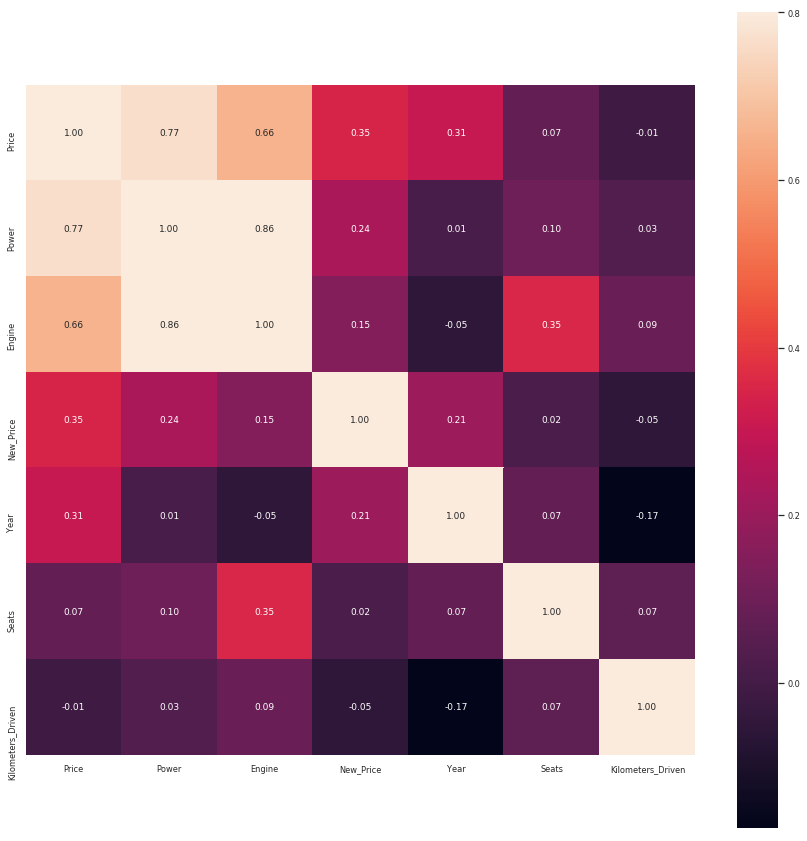

In [57]:
k = 7
min_val_corr = -0.26
corrmat = train.corr()
ser_corr = corrmat.nlargest(k, 'Price')['Price']
cols = ser_corr.index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=0.75)
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(cm, cbar=True, annot=True, square=True, vmax=.8, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [58]:
cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)
print(cols_abv_corr_limit)
print(cols_bel_corr_limit)

['Price', 'Power', 'Engine', 'New_Price', 'Year', 'Seats', 'Kilometers_Driven']
[]


In [59]:
trimed_train = pd.DataFrame(columns=cols_abv_corr_limit)
trimed_test = pd.DataFrame(columns=cols_abv_corr_limit)
for c in cols_abv_corr_limit:
    trimed_train[c] = train[c]
    try:
        trimed_test[c] = test[c]
    except:
        print("column not found")

trimed_test = trimed_test.drop('Price',axis = 1)

for c in trimed_test.select_dtypes(include=['object']).columns:
    trimed_test[c] = pd.to_numeric(trimed_test[c].str.strip().replace("NA", ""))
    trimed_test[c].fillna(trimed_test[c].median(), inplace=True)
# trimed_train = pd.concat([trimed_train, trimed_train], ignore_index=True)

col_train = list(cols_abv_corr_limit)
col_train_bis = list(cols_abv_corr_limit)

col_train_bis.remove('Price')
print(len(col_train))
print(trimed_train.shape)



column not found
7
(6019, 7)


In [60]:
display(trimed_test.head())

,Power,Engine,New_Price,Year,Seats,Kilometers_Driven
0,58.20000,998.0,0.00,2014,4,40929
1,47.30000,796.0,0.00,2013,5,54493
2,147.80000,2393.0,25.27,2017,7,34000
3,110.38042,1364.0,0.00,2012,5,139000
4,82.85000,1197.0,0.00,2014,5,29000


In [61]:
mat_train = np.matrix(trimed_train)
mat_test  = np.matrix(trimed_test)

mat_new = np.matrix(trimed_train.drop('Price',axis = 1))
mat_y = np.array(trimed_train.Price).reshape((6019,1))

#prepro_y = MinMaxScaler()
#prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

# trimed_test.to_csv("output_final_3.csv")
train_set = pd.DataFrame(prepro.transform(trimed_train),columns = col_train)

# test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

display(train_set.head())

,Price,Power,Engine,New_Price,Year,Seats,Kilometers_Driven
0,0.008210,0.045569,0.156261,0.000000,0.571429,0.555556,0.011051
1,0.075583,0.174971,0.254809,0.000000,0.809524,0.555556,0.006282
2,0.025445,0.103652,0.190179,0.086169,0.619048,0.555556,0.007051
3,0.034846,0.103766,0.198448,0.000000,0.666667,0.777778,0.013359
4,0.108423,0.202739,0.319946,0.000000,0.714286,0.555556,0.006231


In [62]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "Price"

# Training set and Prediction set with the features to predict
training_set = train_set[COLUMNS]
prediction_set = training_set.Price

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.4)

train_set_tensor = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set_tensor,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)

# test_loader = torch.utils.data.DataLoader(torch.FloatTensor(test.values),batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [63]:
# Hyperparameters
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1

# Sequence Length
#sequence_length = 6  # of words in a sequence 892110
# Batch Size
# batch_size = 128
# train_loader = batch_data(int_text, sequence_length, batch_size)
# Number of Epochs
num_epochs = 1000
# Learning Rate
learning_rate = 0.002
# Model parameters
# Input size
input_size = cols
# Output size
output_size = 1
# Embedding Dimension
embedding_dim = 128
# Hidden Dimension
hidden_dim = 256
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

In [64]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, input_size, n_layers, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        # self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=output_size)
        self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        # self.fc1 = nn.Linear(input_size, hidden_dim * 2)
        # self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, output_size)
        # self.dropout = nn.Dropout(p=0.25)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.08
        # self.embedding.weight.data.uniform_(-initrange, initrange)
        self.lstm.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm.weight_hh_l0.data.uniform_(-initrange, initrange)
        
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()
        
        # self.fc.bias.data.zero_()
        self.dense.bias.data.fill_(0)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        self.dense.weight.data.normal_(0.0, (1.0 / np.sqrt(self.dense.in_features)))
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        batch_size = x.size(0)
        # print(x.shape)
        # x = x.permute(14, 32)
        # x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        # out = self.fc3(x)
        # x = x.permute(2, 0, 1)
        # print(batch_size)
        # print(x.shape)
        # x = x.t()
        # embeds = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        # avg_pool_l = torch.mean(lstm_out.permute(1, 0, 2), 1)
        # max_pool_l, _ = torch.max(lstm_out.permute(1, 0, 2), 1)
        # print(avg_pool_l)
        # x = torch.cat((avg_pool_l, max_pool_l), 1)
        # print(x.shape)
        out = self.dense(lstm_out)
        # out = self.sig(out.squeeze())
        # print(out)
        # out = out[lengths - 1, range(len(lengths))]
        return out

In [65]:
from torch.autograd import Variable

def forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden_dim, clip=9):

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    hidden = {}
    # hidden = tuple([each.data for each in hidden_dim])
    
    rnn.zero_grad()
    optimizer.zero_grad()
    
    try:
        # get the output from the model
        # output, hidden = rnn(inputs, hidden)
        output = rnn(inputs.unsqueeze(0))
        output = output.squeeze()
        # print(output.shape)
    except RuntimeError:
        raise
    # print(labels)
    loss = criterion(output, labels)
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(),  clip)
   
    optimizer.step()

    return loss.item(), hidden

In [66]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    rnn.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # hidden = rnn.init_hidden(batch_size)
        hidden = {}
        # print("epoch ",epoch_i)
        rnn.train()
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # batch_last = batch_i
            # n_batches = len(train_loader.dataset) // batch_size
            
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden, clip=5)          
            # record loss
            batch_losses.append(loss)
            
        rnn.eval()
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # batch_last = batch_i
            # n_batches = len(val_loader.dataset) // batch_size
            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # if(batch_i > n_batches):
                # break
            try:
                output = rnn(inputs.unsqueeze(0))
                output = output.squeeze()
            except RuntimeError:
                raise
            # print(labels)
            loss = criterion(output, labels)

            val_batch_losses.append(loss.item())

        # printing loss stats
        if epoch_i%show_every_n_batches == 0:
            average_loss = np.average(batch_losses)
            val_average_loss = np.average(val_batch_losses)
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, average_loss, val_average_loss))

            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if val_average_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_average_loss))
                with open('./save/trained_rnn_new', 'wb') as pickle_file:
                    # print(pickle_file)
                    torch.save(rnn, pickle_file)
                valid_loss_min = val_average_loss

            batch_losses = []
            val_batch_losses = []
            
    return rnn

In [67]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [68]:
# create model and move to gpu if available
# rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.25)
# rnn.apply(weight_init)
rnn = LSTMClassifier(embedding_dim, hidden_dim, input_size, n_layers, output_size)
# rnn = torch.load("./save/trained_rnn_new")

if train_on_gpu:
    rnn.cuda()

decay_rate = learning_rate / num_epochs

# print(decay_rate)
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(size_average=False)
#rnn = torch.load("./save/trained_rnn_new")

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
# helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

Training for 1000 epoch(s)...
Epoch: 50 	Training Loss: 0.008711 	Validation Loss: 0.009651
Validation loss decreased (inf --> 0.009651).  Saving model ...
Epoch: 100 	Training Loss: 0.006417 	Validation Loss: 0.007629
Validation loss decreased (0.009651 --> 0.007629).  Saving model ...
Epoch: 150 	Training Loss: 0.005814 	Validation Loss: 0.007180
Validation loss decreased (0.007629 --> 0.007180).  Saving model ...
Epoch: 200 	Training Loss: 0.005495 	Validation Loss: 0.007012
Validation loss decreased (0.007180 --> 0.007012).  Saving model ...
Epoch: 250 	Training Loss: 0.005265 	Validation Loss: 0.006956
Validation loss decreased (0.007012 --> 0.006956).  Saving model ...
Epoch: 300 	Training Loss: 0.005105 	Validation Loss: 0.006904
Validation loss decreased (0.006956 --> 0.006904).  Saving model ...
Epoch: 350 	Training Loss: 0.004909 	Validation Loss: 0.006794
Validation loss decreased (0.006904 --> 0.006794).  Saving model ...
Epoch: 400 	Training Loss: 0.004788 	Validation Loss

In [69]:
def predict(model, inputs):

    if(train_on_gpu):
        inputs = inputs.cuda()
    
    try:
        output = model(inputs.unsqueeze(0))
        output = output.squeeze()
    except RuntimeError:
        raise
    
    # prediction = np.array(output).argmax(0)
    # p = F.softmax(output, dim=1).data
    # p = F.sigmoid(output)
    # p = F.logsigmoid(output)
    p = output.cpu().detach().numpy().flatten()
    # print(p)
    # prediction = np.argmax(p)
    # print(prediction)
    return p

In [56]:
model_rnn = torch.load("./save/trained_rnn_new")
model_rnn.eval()

X = Variable(torch.FloatTensor(X_train.values)) 
pred = predict(model_rnn, X)
print(pred[:30])
# pred= result
print(y_train.values[:30])
r2_score(y_train.values, pred)

# probs = probs[:, 1]
# calculate AUC
# auc = roc_auc_score(y_train, pred)
# print('AUC: %.3f' % auc)
# calculate roc curve
# fpr, tpr, thresholds = roc_curve(y_train, pred)
# plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# show the plot
# pyplot.show()


[0.02163251 0.02769152 0.01534541 0.2628336  0.01304305 0.0277645
 0.06952235 0.26327062 0.08098412 0.02727779 0.01592193 0.02485628
 0.02506906 0.0209416  0.0395494  0.02229825 0.02453362 0.01715811
 0.03568545 0.0446648  0.05519942 0.01162158 0.08242645 0.10609452
 0.04363153 0.16265534 0.01913129 0.02132364 0.00727497 0.03309163]
[0.02450489 0.02857859 0.02293808 0.23853096 0.01598145 0.0088368
 0.02638506 0.18757834 0.06994234 0.02168463 0.0213086  0.01604412
 0.01917774 0.01479067 0.04105039 0.02149662 0.01447731 0.01479067
 0.05114064 0.03797944 0.05483831 0.00821008 0.06931562 0.08673853
 0.04719228 0.23539734 0.01416395 0.02074455 0.00413638 0.02795187]


0.8753702337660044

In [73]:
display(test_set.head())

,Power,Engine,New_Price,Year,Seats,Kilometers_Driven,Owner_Type,Location,Car_Brand,Mileage
0,0.045645,0.156261,0.000000,0.761905,0.444444,0.006271,0.000000,0.4,0.580645,0.961837
1,0.024914,0.122173,0.000000,0.714286,0.555556,0.008357,0.666667,0.3,0.580645,0.309302
2,0.216052,0.391664,0.252902,0.904762,0.777778,0.005205,0.000000,0.9,0.935484,0.171306
3,0.144885,0.218022,0.000000,0.666667,0.555556,0.021359,0.000000,0.5,0.935484,0.295403
4,0.092526,0.189841,0.000000,0.761905,0.555556,0.004435,0.000000,0.9,0.354839,0.231664


In [74]:
test_X = Variable(torch.FloatTensor(test_set.values))
print(test_X)
test_pred = predict(model_rnn, test_X)
print(test_pred)
print(len(test_pred))
# print(np.array(test_p).reshape(9614,1))

tensor([[0.0456, 0.1563, 0.0000,  ..., 0.4000, 0.5806, 0.9618],
        [0.0249, 0.1222, 0.0000,  ..., 0.3000, 0.5806, 0.3093],
        [0.2161, 0.3917, 0.2529,  ..., 0.9000, 0.9355, 0.1713],
        ...,
        [0.0550, 0.2344, 0.0000,  ..., 0.8000, 0.7097, 0.2890],
        [0.1320, 0.1898, 0.0000,  ..., 1.0000, 0.9677, 0.2154],
        [0.2583, 0.3503, 0.0000,  ..., 0.7000, 0.6129, 0.1252]])
[0.01872441 0.01644361 0.10547267 ... 0.02156052 0.01810172 0.12582707]
1234


In [75]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(test_pred).reshape(1234,1)), columns = ["Price"])
# predictions = pd.DataFrame(np.array(test_pred).reshape(8037,1), columns = ["FORECLOSURE"])
# predictions["FORECLOSURE"] = predictions["FORECLOSURE"]
# predictions['SalePrice'] = predictions['SalePrice']
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 0 if x < 0.01 else 1)
# predictions['FORECLOSURE'] = predictions['FORECLOSURE'].apply(lambda x: 1 if x > 0 else x)
# predictions = predictions.round(2)
#predictions["Id"] = test_csv["Id"]
display(predictions.head())

,Price
0,3.427667
1,3.063742
2,17.269220
3,5.060642
4,4.626063


In [77]:
predictions.to_csv("submission_3.csv", index=False)